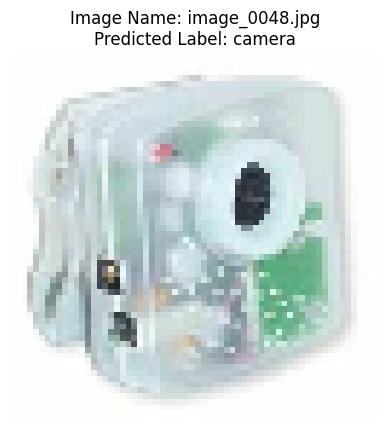

In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import cupy as cp

class_names = [
    "accordion", "airplanes", "anchor", "ant", "BACKGROUND_Google",
    "barrel", "bass", "beaver", "binocular", "bonsai",
    "brain", "brontosaurus", "buddha", "butterfly", "camera"
]

# Define the base directory
base_directory = "/content/drive/MyDrive/HWData/"

# Read and resize images, convert to vector format
def read_resize_images(directory, image_size=(64, 64)):
    images = []
    for filename in os.listdir(directory):
        img = cv2.imread(os.path.join(directory, filename))
        img_resized = cv2.resize(img, image_size)
        img_vector = cp.asarray(img_resized.flatten())
        images.append(img_vector)
    return cp.array(images)

# Apply PCA
def apply_pca(data_list):
    eigenvectors_list = []
    for data in data_list:
        covariance_matrix = cp.cov(data.T)
        eigenvalues, eigenvectors = cp.linalg.eigh(covariance_matrix)
        sorted_indices = cp.argsort(eigenvalues)[::-1]
        top_eigenvectors = eigenvectors[:, sorted_indices[:3]]
        eigenvectors_list.append(top_eigenvectors)
    return eigenvectors_list

# Project data onto selected eigenvectors
def project_data(data, eigenvectors):
    return cp.dot(data, eigenvectors)

# Test an image
def test_image(test_image, train_features, eigenvectors):
    test_feature = project_data(test_image, eigenvectors)
    distances = cp.array([cp.sum(cp.abs(test_feature - train_feature)) for train_feature in train_features])
    min_distance_index = cp.argmin(distances)
    return min_distance_index  # Class index starts from 0

# Choose a random folder and a random photo from the test directory
random_folder = random.choice(os.listdir(os.path.join(base_directory, "test")))
random_image = random.choice(os.listdir(os.path.join(base_directory, "test", random_folder)))
test_image_path = os.path.join(base_directory, "test", random_folder, random_image)

# Read and resize the random image
test_img = cv2.imread(test_image_path)
test_img_resized = cv2.resize(test_img, (64, 64))

# Load train data
train_data = []
for class_name in class_names:
    class_directory = os.path.join(base_directory, "train", class_name)
    class_images = read_resize_images(class_directory)
    train_data.append(class_images)

# Apply PCA
eigenvectors_list = apply_pca(train_data)

# Project train data onto selected eigenvectors
train_features = [project_data(class_data, eigenvectors) for class_data, eigenvectors in zip(train_data, eigenvectors_list)]

# Convert the random image to vector format
test_img_vector = cp.asarray(test_img_resized.flatten())

# Predict the label of the random image
min_distance_index = test_image(test_img_vector, train_features, eigenvectors_list[class_names.index(random_folder)])
predicted_class_name = class_names[int(min_distance_index)]

# Display the image, its name, and predicted label
plt.imshow(cv2.cvtColor(test_img_resized, cv2.COLOR_BGR2RGB))
plt.title(f"Image Name: {random_image}\nPredicted Label: {predicted_class_name}")
plt.axis('off')
plt.show()
